In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Flatten
from sklearn.decomposition import PCA
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import keras
import random
import numpy as np
import csv
import requests
import tensorflow
import os
import requests


In [24]:

url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/RECORDS'

response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:

    text = response.text
    print("Successfully retrieve the patient Id's Status code:", response.status_code)
else:
    print("Failed to retrieve the text content. Status code:", response.status_code)

lines = text.strip().split('\n')

csv_file = 'record_names.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[line] for line in lines])

print(f'CSV file "{csv_file}" has been created.')


Successfully retrieve the patient Id's Status code: 200
CSV file "record_names.csv" has been created.


In [25]:

csv_file = 'record_names.csv'

patient_ids_df = pd.read_csv(csv_file, header=None)

patient_ids = patient_ids_df.to_numpy().reshape(-1)

print(patient_ids)

['v100s' 'v101l' 'v102s' 'a103l' 'a104s' 'a105l' 't106s' 't107l' 't108s'
 'a109l' 't110s' 'v111l' 't112s' 'v113l' 't114s' 'v115l' 't116s' 't117l'
 't118s' 'v119l' 'f120s' 'f121l' 'v122s' 'a123l' 'b124s' 'b125l' 'b126s'
 'v127l' 'v128s' 'f129l' 'f130s' 'v131l' 'v132s' 'v133l' 'a134s' 'v135l'
 'v136s' 'f137l' 'f138s' 'v139l' 'v140s' 'v141l' 'a142s' 'v143l' 'f144s'
 'a145l' 'v146s' 'v147l' 'v148s' 't149l' 't150s' 't151l' 'a152s' 'v153l'
 'v154s' 'v155l' 't156s' 't157l' 'v158s' 'v159l' 'v160s' 'a161l' 'v162s'
 'a163l' 'v164s' 'a165l' 'v166s' 'a167l' 'v168s' 'v169l' 'a170s' 'a171l'
 'a172s' 't173l' 't174s' 't175l' 'v176s' 'v177l' 'a178s' 'v179l' 'v180s'
 'v181l' 'v182s' 'b183l' 'b184s' 'a185l' 'a186s' 'b187l' 'v188s' 'f189l'
 'f190s' 't191l' 't192s' 't193l' 'v194s' 't195l' 'f196s' 'v197l' 'v198s'
 'v199l' 'v200s' 'v201l' 'v202s' 'a203l' 'v204s' 'v205l' 'v206s' 'v207l'
 't208s' 't209l' 'v210s' 'v211l' 'v212s' 't213l' 't214s' 'b215l' 'b216s'
 'v217l' 'v218s' 'a219l' 'b220s' 'v221l' 'v222s' 'a

In [ ]:

def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        print(f"Downloading {url}...")
        r = requests.get(url)
        if r.status_code == 200:
            with open(dest_path, 'wb') as f:
                f.write(r.content)
            print(f"Saved to {dest_path}")
        else:
            print(f"Failed to download {url}. Status code: {r.status_code}")
    else:
        print(f"File already exists: {dest_path}")

def extracting_database(record_name, data_dir='./training'):
    os.makedirs(data_dir, exist_ok=True)

    base_url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/'

    mat_url = f"{base_url}{record_name}.mat"
    hea_url = f"{base_url}{record_name}.hea"

    record_path = os.path.join(data_dir, f"{record_name}.mat")
    hea_file_path = os.path.join(data_dir, f"{record_name}.hea")

    download_file(mat_url, record_path)
    download_file(hea_url, hea_file_path)

    return record_path, hea_file_path


In [27]:
def extract_pleth_info(file_path):

    pleth_info = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

        first_line_info = lines[0].split()
        pleth_info['file_name'] = first_line_info[0]
        pleth_info['num_signals'] = int(first_line_info[1])
        pleth_info['frequency'] = int(first_line_info[2])
        pleth_info['num_samples'] = int(first_line_info[3])

        last_three_lines = lines[-3:]
        pleth_info['ADC_resolution'] = last_three_lines[0].split()[1]
        pleth_info['ADC_gain'] = last_three_lines[0].split()[2]
        pleth_info['ADC_bits'] = int(last_three_lines[0].split()[3])
        pleth_info['ADC_zero'] = int(last_three_lines[0].split()[4])
        pleth_info['initial_value'] = int(last_three_lines[0].split()[5])
        pleth_info['check_sum'] = int(last_three_lines[0].split()[6])
        pleth_info['block_size'] = int(last_three_lines[0].split()[7])
        pleth_info['description'] = last_three_lines[0].split()[8]
        pleth_info['electrical_activity'] = last_three_lines[1].replace("#", "").replace("\n", "")
        pleth_info['validity'] = last_three_lines[2].replace("#", "").replace("\n", "")
        return pleth_info

file_path = hea_file_path
pleth_info = extract_pleth_info(file_path)
pleth_info

{'file_name': 'a103l',
 'num_signals': 3,
 'frequency': 250,
 'num_samples': 82500,
 'ADC_resolution': '16+24',
 'ADC_gain': '1.253e+04/NU',
 'ADC_bits': 16,
 'ADC_zero': 0,
 'initial_value': 6042,
 'check_sum': -17391,
 'block_size': 0,
 'description': 'PLETH',
 'electrical_activity': 'Asystole',
 'validity': 'False alarm'}

In [7]:
import os
import scipy.io
def extract_pleth_signal(record_path):

    mat_data = scipy.io.loadmat(record_path)

    signals = mat_data['val']

    pleth_signal = signals[2]  # PLETH is the third signal

    return pleth_signal

record_name = 'a103l'
record_path, hea_file_path = extracting_database(record_name)
pleth_signal = extract_pleth_signal(record_path)
pleth_signal

File already exists: ./training/a103l.mat
File already exists: ./training/a103l.hea


array([6042, 6821, 5992, ..., 6454, 6385, 6301], dtype=int16)

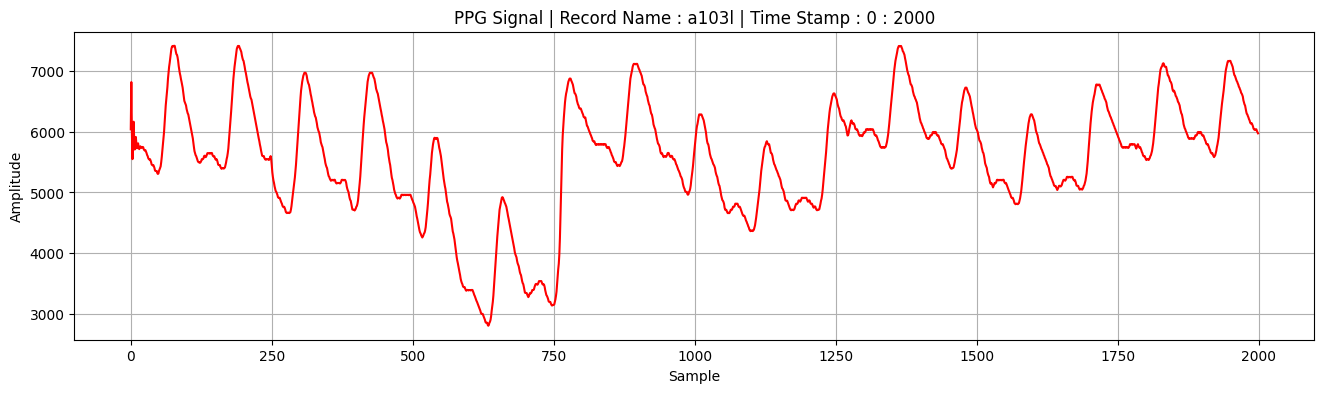

In [29]:

InitialTime = 0
FinalTime = 2000

plt.figure(figsize=(16, 4))
plt.plot(pleth_signal[InitialTime : FinalTime], color='red')
plt.title('PPG Signal | Record Name : ' + str(record_name) +" | Time Stamp : "+ str(InitialTime) + " : " + str(FinalTime))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [30]:
pleth_infos = {}
pleth_signals = {}

count = len(patient_ids)
i = 0
for patient_id in patient_ids:

    # Download the files and get their paths
    record_path, hea_file_path = extracting_database(patient_id)

    print("Signal of patient " + str(patient_id) + " extracted")

    # Extract PLETH signal
    pleth_signal = extract_pleth_signal(record_path)
    pleth_signals[patient_id] = pleth_signal

    print("PPG of patient " + str(patient_id) + " loaded")

    # Extract PLETH information
    pleth_info = extract_pleth_info(hea_file_path)
    pleth_infos[patient_id] = pleth_info

    print("Info of patient " + str(patient_id) + " loaded")

    print("PPG and info extracted for " + str(i+1) + " and " + str(count - i - 1) + " left.")

    i += 1


Streaming output truncated to the last 5000 lines.
Saved to ./training/a225l.mat
Saved to ./training/a225l.hea
Signal of patient a225l extracted
PPG of patient a225l loaded
Info of patient a225l loaded
PPG and info extracted for 126 and 624 left.
Saved to ./training/a226s.mat
Saved to ./training/a226s.hea
Signal of patient a226s extracted
PPG of patient a226s loaded
Info of patient a226s loaded
PPG and info extracted for 127 and 623 left.
Saved to ./training/b227l.mat
Saved to ./training/b227l.hea
Signal of patient b227l extracted
PPG of patient b227l loaded
Info of patient b227l loaded
PPG and info extracted for 128 and 622 left.
Saved to ./training/b228s.mat
Saved to ./training/b228s.hea
Signal of patient b228s extracted
PPG of patient b228s loaded
Info of patient b228s loaded
PPG and info extracted for 129 and 621 left.
Saved to ./training/b229l.mat
Saved to ./training/b229l.hea
Signal of patient b229l extracted
PPG of patient b229l loaded
Info of patient b229l loaded
PPG and info e

In [32]:
pleth_infos[str(patient_ids[400])]

{'file_name': 'f500s',
 'num_signals': 4,
 'frequency': 250,
 'num_samples': 75000,
 'ADC_resolution': '16+24',
 'ADC_gain': '47.8/mmHg',
 'ADC_bits': 16,
 'ADC_zero': 0,
 'initial_value': 4912,
 'check_sum': 23760,
 'block_size': 0,
 'description': 'ABP',
 'electrical_activity': 'Ventricular_Flutter_Fib',
 'validity': 'False alarm'}

In [33]:
unique_frequencies = set()

for signal_data in pleth_infos.values():
    unique_frequencies.add(signal_data['frequency'])

print("Unique sample frequencies:", unique_frequencies)

Unique sample frequencies: {250}


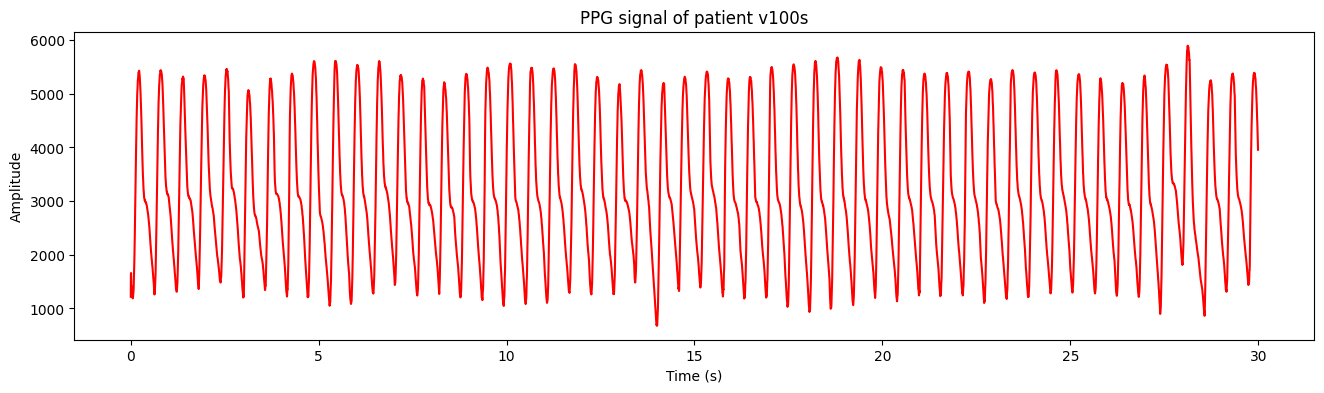

In [75]:
def plot_ppg_signal(patient_id, starting_time, ending_time):
    pleth_info = pleth_infos[str(patient_id)]
    sampling_frequency = pleth_info['frequency']

    starting_signal_point = int(starting_time * sampling_frequency)
    ending_signal_point = int(ending_time * sampling_frequency)

    x = np.arange(starting_time, ending_time, 1 / sampling_frequency)

    signal = pleth_signals[str(patient_id)][starting_signal_point:ending_signal_point]

    plt.figure(figsize=(16, 4))
    plt.plot(x, signal, color='red')
    plt.title(f'PPG signal of patient {patient_id}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

plot_ppg_signal(patient_ids[0], 0, 30)


In [110]:

from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    if highcut >= nyquist or lowcut <= 0 or lowcut >= highcut:
        raise ValueError("Invalid bandpass frequency range. Must satisfy: 0 < lowcut < highcut < Nyquist.")

    low = lowcut / nyquist
    high = highcut / nyquist
    order = 3  # Filter order

    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

def savitzky_golay(signal, window_length=21, polyorder=3):
    if len(signal) < window_length:
        window_length = len(signal) if len(signal) % 2 == 1 else len(signal) - 1
    if window_length < polyorder + 2:
        window_length = polyorder + 2
    if window_length % 2 == 0:
        window_length += 1  # window_length harus ganjil
    if len(signal) < window_length:
        return signal  # kalau masih kependekan, balikin signal original saja

    smoothed = savgol_filter(signal, window_length, polyorder)
    return smoothed

def normalize_signal(signal):
# Normalize signal using Min-Max scaling
    normalized_signal = (signal - np.min(signal)) /  np.std(pleth_signal)


    return normalized_signal

In [111]:

def segment_signal(signal, segment_length, fs):

    num_samples_per_segment = int(segment_length * fs)
    num_segments = len(signal) // num_samples_per_segment
    segmented_signal = [signal[i * num_samples_per_segment: (i + 1) * num_samples_per_segment]
                        for i in range(num_segments)]
    return segmented_signal

In [63]:
%pip install PyWavelets


In [186]:
from scipy.signal import butter, filtfilt
import pywt
fs = pleth_info['frequency']
segmented_signal = segment_signal(pleth_signal, 30, fs)

processed_segments = []

for segment in segmented_signal:
    # Bandpass filter
    segment_processed = bandpass_filter(segment, lowcut=0.4, highcut=30, fs=fs)

    #Savitzky-Golay filter (pastikan window_length ganjil dan <= panjang sinyal)
    window_length = min(51, len(segment_processed) if len(segment_processed) % 2 == 1 else len(segment_processed) - 1)
    polyorder = 3
    if window_length > polyorder:
        segment_processed = savitzky_golay(segment_processed, window_length, polyorder)


    segment_processed = remove_baseline_wandering(segment_processed)

    segment_processed = normalize_signal(segment_processed)

    processed_segments.append(segment_processed)


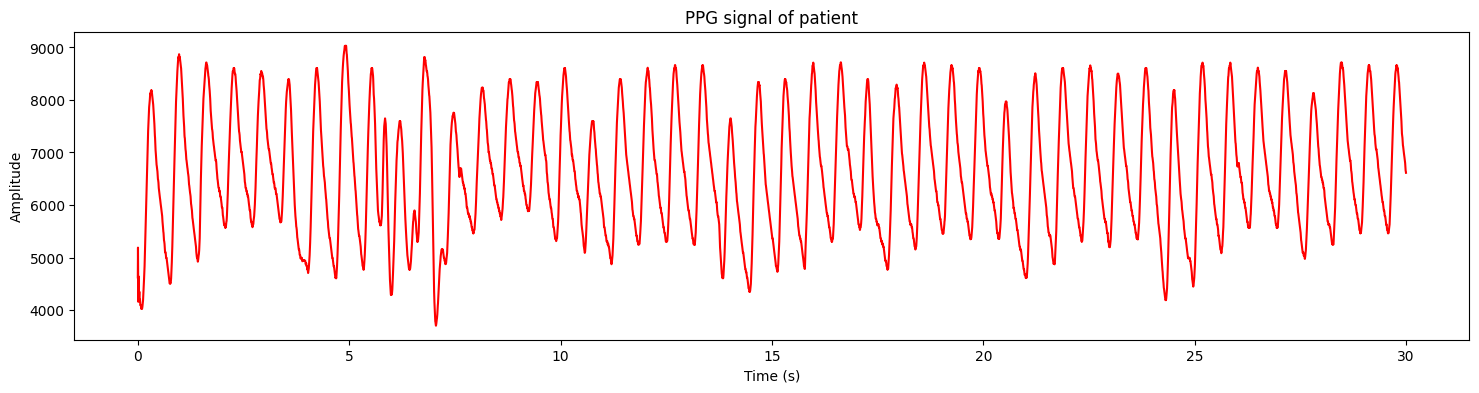

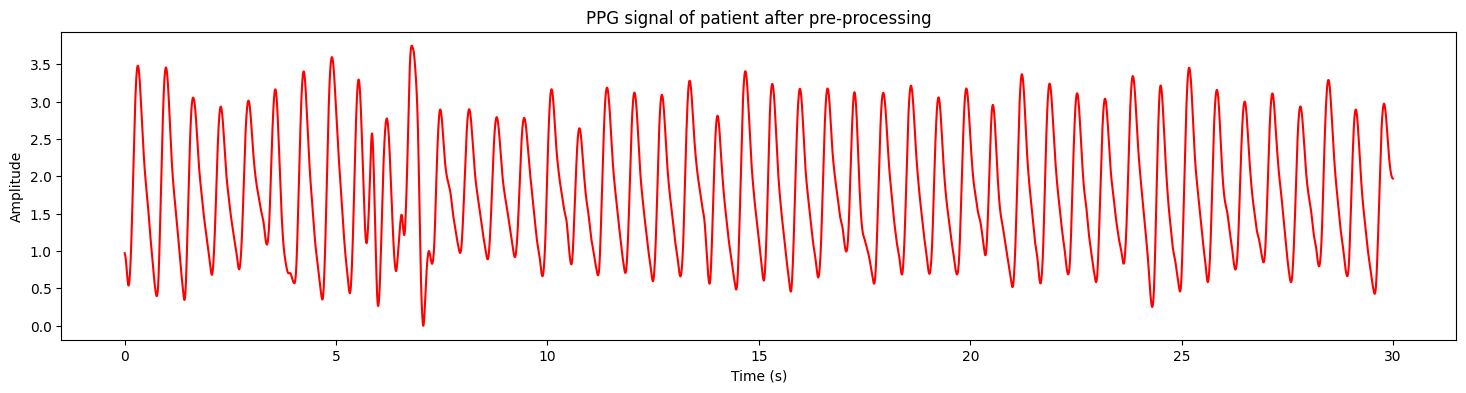

In [187]:
def plot_ppg_signal_sampled(pleth_signal, fs, starting_time, ending_time):

    starting_signal_point = int(starting_time * fs)
    ending_signal_point = int(ending_time * fs)

    x = np.arange(starting_time, ending_time, 1 / fs)

    signal = pleth_signal[starting_signal_point:ending_signal_point]

    plt.figure(figsize=(18, 4))
    plt.plot(x, signal, color='red')
    plt.title(f'PPG signal of patient')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
plot_ppg_signal_sampled(pleth_signal, fs, 0, 30)
x_processed = np.arange(0, len(processed_segments[0]) / fs, 1 / fs)

plt.figure(figsize=(18, 4))
plt.plot(x_processed, processed_segments[0], color='red')
plt.title('PPG signal of patient after pre-processing')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [193]:
from scipy.integrate import trapezoid
from scipy import stats
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

def extract_ppg_features(ppg_signal, fs):
    # Peak Detection with higher threshold
    peak_height_threshold = 0.5 * (np.percentile(ppg_signal, 75) + np.median(ppg_signal))  # Might have to adjust accordingly
    peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold)

    peak_features = []

    prev_peak_index = None

    for peak_index in peaks:
        # Define window size (0.5 seconds window)
        window_size = int(fs * 2)  # Example: 2-second window around each peak
        peak_window = ppg_signal[max(0, peak_index - window_size):min(len(ppg_signal), peak_index + window_size)]

        # Calculate peak height (amplitude)
        peak_height = ppg_signal[peak_index]

        # Calculate peak-to-peak interval (time between consecutive peaks)
        if prev_peak_index is not None:
            peak_to_peak_interval = (peak_index - prev_peak_index) / fs  # in seconds
        else:
            peak_to_peak_interval = np.nan  # For the first peak

        # Morphological Features
        sa = np.max(peak_window)
        Da = np.min(peak_window)
        SA = trapezoid(peak_window, dx=1/fs)  # Updated: Use trapezoid for numerical integration
        DA = trapezoid(peak_window, dx=1/fs) - SA  # Updated: Use trapezoid for numerical integration
        St = peak_index / fs
        Dt = (len(ppg_signal) - peak_index) / fs

        # Frequency Domain Features
        fft_result = fft(peak_window)
        magnitude_spectrum = np.abs(fft_result)
        frequency_spectrum = np.fft.fftfreq(len(peak_window), d=1/fs)
        dominant_frequency = frequency_spectrum[np.argmax(magnitude_spectrum)]
        pmf = magnitude_spectrum / np.sum(magnitude_spectrum)
        spectral_entropy = -np.sum(pmf * np.log2(pmf + 1e-10))

        # Additional features
        if prev_peak_index is not None:
            ppi = (peak_index - prev_peak_index) / fs
        else:
            ppi = 0

        pi = ppi
        pw = calculate_pulse_width(peak_window, fs)
        fwhm = calculate_fwhm(peak_window, fs)

        signal_area = trapezoid(ppg_signal, dx=1/fs)  # Updated: Use trapezoid for numerical integration
        rise_time = St - (max(0, peak_index - window_size)) / fs
        fall_time = (min(len(ppg_signal), peak_index + window_size) - peak_index) / fs

        amplitude_modulation_depth = sa - Da
        energy = np.sum(peak_window ** 2)
        zero_crossing_rate = calculate_zero_crossing_rate(peak_window)

        # Statistical Features
        mean = np.mean(peak_window)
        median = np.median(peak_window)
        std_deviation = np.std(peak_window)
        skewness = stats.skew(peak_window)
        kurtosis = stats.kurtosis(peak_window)
        min_value = np.min(peak_window)
        max_value = np.max(peak_window)
        variance = np.var(peak_window)

        # Additional features
        slope = calculate_slope(peak_window, fs)
        peak_count = len(peaks)

        # Handle exceptions for divide by zero errors
        try:
            amplitude_ratio = sa / Da if Da != 0 else 0
            area_ratio = SA / DA if DA != 0 else np.nan  # Updated to avoid 'inf'
            interval_ratio = pi / ppi if ppi != 0 else 0
        except ZeroDivisionError:
            amplitude_ratio = 0
            area_ratio = np.nan  # Set to np.nan if DA is zero
            interval_ratio = 0

        # Append all features to the list
        peak_features.append({
            'sa': sa, 'Da': Da, 'SA': SA, 'DA': DA,
            'St': St, 'Dt': Dt,
            'PI': pi, 'PPI': ppi, 'PW': pw, 'FWHM': fwhm,
            'Dominant_frequency': dominant_frequency,
            'Spectral_entropy': spectral_entropy,
            'Signal_area': signal_area,
            'Rise_time': rise_time,
            'Fall_time': fall_time,
            'Amplitude_modulation_depth': amplitude_modulation_depth,
            'Energy': energy,
            'Zero_crossing_rate': zero_crossing_rate,
            'Mean': mean,
            'Median': median,
            'Standard_deviation': std_deviation,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Min_value': min_value,
            'Max_value': max_value,
            'Variance': variance,
            'Slope': slope,
            'Peak_count': peak_count,
            'Amplitude_ratio': amplitude_ratio,
            'Area_ratio': area_ratio,  # Area ratio safely handled
            'Interval_ratio': interval_ratio
        })

        prev_peak_index = peak_index

    return peak_features, peaks



In [192]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

def detect_prominent_peaks(ppg_signal, fs, prominence=0.5, distance=100, width=None):
    # Calculate the peak height threshold based on a percentage of the maximum amplitude
    peak_height_threshold = prominence * np.max(ppg_signal)

    # Find peaks above the threshold with optional controls for distance and width
    peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold, distance=distance, width=width)

    # Plot the PPG signal with detected peaks for visualization
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(ppg_signal)) / fs, ppg_signal, label='PPG signal')
    plt.plot(peaks / fs, ppg_signal[peaks], 'ro', label='Detected Prominent Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('PPG Signal with Detected Prominent Peaks')
    plt.legend()
    plt.grid(True)
    plt.show()

    return peaks


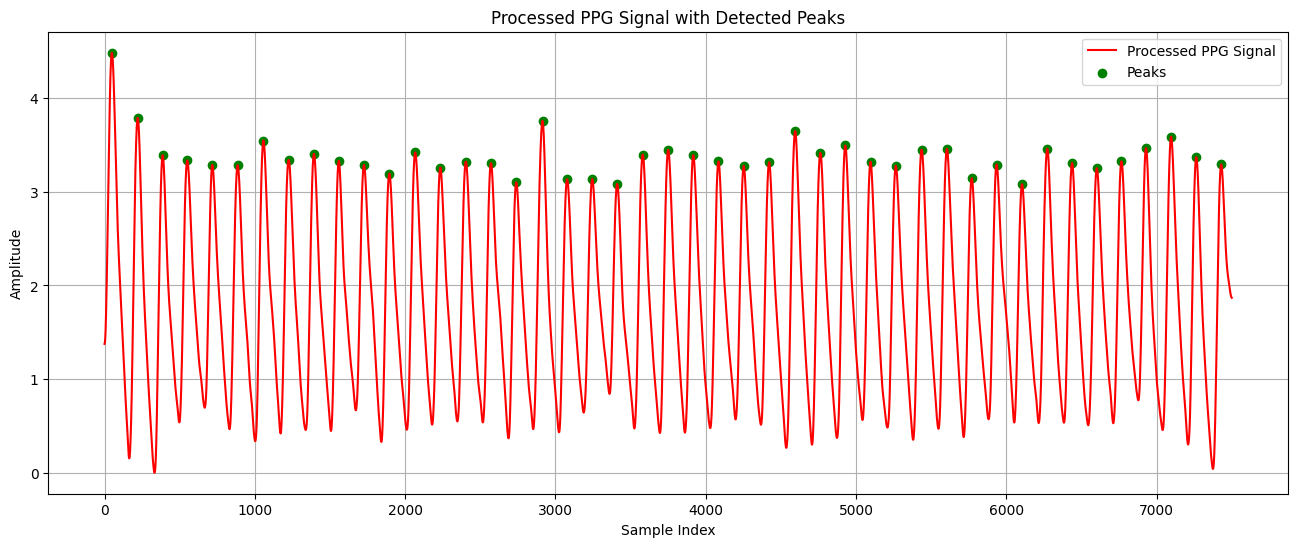

In [194]:
from scipy.integrate import trapezoid
# Assuming `extract_ppg_features` returns peak features and peak points
features, peaks = extract_ppg_features(processed_segments[6], fs)

# Plot the processed PPG signal
plt.figure(figsize=(16, 6))
plt.plot(processed_segments[6], label='Processed PPG Signal', color='red')

# Plot the detected peaks
plt.scatter(peaks, processed_segments[6][peaks], color='green', label='Peaks')

plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Processed PPG Signal with Detected Peaks')
plt.legend()
plt.grid(True)
plt.show()

In [195]:
features, peaks = extract_ppg_features(processed_segments[0],fs)

In [196]:
features

[{'sa': np.float64(3.4798716950551087),
  'Da': np.float64(0.3456682692098107),
  'SA': np.float64(4.143817005516356),
  'DA': np.float64(0.0),
  'St': np.float64(0.312),
  'Dt': np.float64(29.688),
  'PI': 0,
  'PPI': 0,
  'PW': np.float64(2.12),
  'FWHM': np.float64(2.12),
  'Dominant_frequency': np.float64(0.0),
  'Spectral_entropy': np.float64(5.7851218373758115),
  'Signal_area': np.float64(53.48176608542087),
  'Rise_time': np.float64(0.312),
  'Fall_time': np.float64(2.0),
  'Amplitude_modulation_depth': np.float64(3.134203425845298),
  'Energy': np.float64(2378.552415334194),
  'Zero_crossing_rate': np.float64(0.0),
  'Mean': np.float64(1.7955900152635276),
  'Median': np.float64(1.6971701951808946),
  'Standard_deviation': np.float64(0.9439274782361755),
  'Skewness': np.float64(0.20516919190652252),
  'Kurtosis': np.float64(-1.2650036743766855),
  'Min_value': np.float64(0.3456682692098107),
  'Max_value': np.float64(3.4798716950551087),
  'Variance': np.float64(0.89099908416

In [224]:
def plot_multiple_ppg_with_peaks(ppg_signals, fs):
    plt.figure(figsize=(20, 10))
    all_peaks = []  # List to store all prominent peaks

    for i, ppg_signal in enumerate(ppg_signals):
        duration = len(ppg_signal) / fs
        time = np.linspace(0, duration, len(ppg_signal))

        # Plot PPG signal
        plt.plot(time, ppg_signal, label=f'PPG Signal {i+1}')

        # Adjust peak detection threshold
        peak_height_threshold = 0.5 * np.max(ppg_signal)
        peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold, distance=100)

        all_peaks.append(peaks)  # Store the peaks for all signals

    # Plot all prominent peaks together
    all_peaks_flat = [peak / fs for peaks in all_peaks for peak in peaks]
    all_peaks_amplitudes = [ppg_signal[peak] for peaks, ppg_signal in zip(all_peaks, ppg_signals) for peak in peaks]

    # Scatter plot for all peaks
    plt.scatter(all_peaks_flat, all_peaks_amplitudes, color='red', label='Prominent Peaks')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Multiple PPG Signals with Prominent Peaks')
    plt.legend()
    plt.grid(True)
    plt.show()



In [226]:
plot_multiple_ppg_with_peaks(processed_segments, fs)

KeyboardInterrupt: 

In [ ]:
# Apply PCA to reduce dimensionality of extracted features
def apply_pca(features, n_components=10):
    pca = PCA(n_components=n_components)
    scaled_features = StandardScaler().fit_transform(features)  # Scale features before PCA
    pca_features = pca.fit_transform(scaled_features)
    return pca_features

# Prepare dataset with PCA
dataset = []
i = 0
for label, patient_ids in patient_ids_by_activity.items():
    for patient_id in patient_ids:
        if patient_id not in pleth_signals:
            print(f"Patient ID {patient_id} not found in pleth_signal dictionary")
            continue
        fs = pleth_infos[patient_id]['frequency']
        segmented_signal = segment_signal(pleth_signals[patient_id], 10, fs)

        for segment in segmented_signal:
            segment_processed = bandpass_filter(segment, lowcut=0.05, highcut=10, fs=fs)
            segment_processed = moving_average(segment_processed, window_size=3)
            segment_processed = remove_baseline_wandering(segment_processed)

            if not any(segment_processed):
                continue

            features = extract_ppg_features(segment_processed, fs)
            for feature in features:
                peak_array = [feature[key] for key in feature.keys()]
                dataset.append((label, peak_array))
                i += 1

# Prepare labels and features for training
labels = [label for label, _ in dataset]
signals = [signal for _, signal in dataset]

# One-hot encode the labels
unique_labels = set(labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}
encoded_labels = [to_categorical(label_to_index[label], num_classes=len(unique_labels)) for label in labels]

# Apply PCA to features
features = [feature for _, feature in dataset]
pca_features = apply_pca(features, n_components=10)

# Padding the sequences
max_length = max(len(signal) for signal in signals)
padded_signals = [np.pad(signal, (0, max_length - len(signal))) for signal in signals]

# Convert to numpy arrays
X = np.array(padded_signals)
y = np.array(encoded_labels)

# Add PCA features as additional input
X_pca = np.hstack([X.reshape(X.shape[0], -1), pca_features])

# Reshape for LSTM/BiLSTM input (no PCA in this section)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Reshaping for LSTM/BiLSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [198]:
electrical_activity_counts = {}

for patient_info in pleth_infos.values():
    electrical_activity = patient_info.get('electrical_activity')
    electrical_activity_counts[electrical_activity] = electrical_activity_counts.get(electrical_activity, 0) + 1
print("Unique electrical activities and their counts:")
for activity, count in electrical_activity_counts.items():
    print(f"{activity}: {count}")

Unique electrical activities and their counts:
Ventricular_Tachycardia: 341
Asystole: 122
Tachycardia: 140
Ventricular_Flutter_Fib: 58
Bradycardia: 89


In [199]:
# Initialize a dictionary to store patient IDs for each unique electrical activity
patient_ids_by_activity = {}

# Iterate through the nested dictionaries in pleth_infos
for patient_id, patient_info in pleth_infos.items():
    # Extract the electrical activity for the current patient
    electrical_activity = patient_info.get('electrical_activity')
    # Extract the validity of the electrical activity
    validity = patient_info.get('validity')

    # Check if the validity is 'True alarm'
    if validity == 'True alarm':
        # Add the patient ID to the list associated with the electrical activity
        if electrical_activity:
            if electrical_activity not in patient_ids_by_activity:
                patient_ids_by_activity[electrical_activity] = []
            patient_ids_by_activity[electrical_activity].append(patient_id)

# Print the list of patient IDs for each unique electrical activity
print("List of patient IDs for each unique electrical activity with validity 'True alarm':")
for activity, patient_ids in patient_ids_by_activity.items():
    print(f"{activity}: {patient_ids}")


List of patient IDs for each unique electrical activity with validity 'True alarm':
Tachycardia: ['t106s', 't107l', 't108s', 't110s', 't112s', 't114s', 't117l', 't118s', 't149l', 't150s', 't151l', 't156s', 't157l', 't173l', 't174s', 't175l', 't191l', 't192s', 't193l', 't195l', 't208s', 't209l', 't213l', 't214s', 't234s', 't235l', 't238s', 't240s', 't249l', 't251l', 't252s', 't263l', 't264s', 't270s', 't276s', 't277l', 't284s', 't300s', 't305l', 't320s', 't333l', 't335l', 't342s', 't343l', 't344s', 't350s', 't351l', 't356s', 't357l', 't358s', 't393l', 't394s', 't406s', 't410s', 't411l', 't412s', 't413l', 't416s', 't417l', 't418s', 't424s', 't425l', 't430s', 't434s', 't444s', 't445l', 't447l', 't458s', 't467l', 't468s', 't477l', 't478s', 't506s', 't507l', 't508s', 't509l', 't520s', 't521l', 't524s', 't546s', 't547l', 't565l', 't567l', 't577l', 't580s', 't589l', 't594s', 't595l', 't614s', 't622s', 't662s', 't665l', 't677l', 't678s', 't679l', 't680s', 't683l', 't688s', 't689l', 't690s', 't

In [207]:
max_length = 6

for key, arr in patient_ids_by_activity.items():
    if len(arr) > max_length:
        patient_ids_by_activity[key] = arr[:max_length]


In [214]:
dataset = []
i = 0
for label, patient_ids in patient_ids_by_activity.items():
    for patient_id in patient_ids:
        if patient_id not in pleth_signals:
            print(f"Patient ID {patient_id} not found in pleth_signal dictionary")
            continue

        fs = pleth_infos[patient_id]['frequency']
        segmented_signal = segment_signal(pleth_signals[patient_id], 10, fs)

        for segment in segmented_signal:
            segment_processed = bandpass_filter(segment, lowcut=0.05, highcut=30, fs=fs)
            segment_processed = moving_average(segment_processed, window_size=int(0.02*fs))

            window_length = min(51, len(segment_processed) if len(segment_processed) % 2 == 1 else len(segment_processed) - 1)
            polyorder = 3
            segment_processed = savitzky_golay(segment_processed, window_length, polyorder)

            if segment_processed is not None and len(segment_processed.shape) == 1 and len(segment_processed) > 0:
                segment_processed = remove_baseline_wandering(segment_processed)
            else:
                    print(f"Skipping baseline removal, segment shape: {segment_processed.shape if segment_processed is not None else 'None'}")

            segment_processed = normalize_signal(segment_processed)
            processed_segments.append(segment_processed)

            # Skip empty segments after processing
            if not any(segment_processed):
                continue

            # Normalize the signal
            segment_processed = normalize_signal(segment_processed)

            # Append the processed signal to the dataset
            dataset.append((label, segment_processed))

            # Extract features and peaks
            features, peaks = extract_ppg_features(segment_processed, fs)
            for feature in features:
                # Create an array of the feature values and append it to the dataset
                peak_array = [feature[key] for key in feature.keys()]

                # Appending the label and peak array (instead of segment_processed, which is already added)
                dataset.append((label, peak_array))

                i += 1

# Print the total number of features processed
print(f"Total features processed: {i}",f"Total dataset entries: {len(dataset)}")


Total features processed: 11838 Total dataset entries: 12759


In [210]:
len(dataset)

12759

In [ ]:

# Create LSTM model with ANN after LSTM
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),  # Adding ANN layer after LSTM
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create BiLSTM model with ANN after BiLSTM
def create_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(64)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),  # Adding ANN layer after BiLSTM
        Dense(num_classes, activation='softmax')
    ])
    return model

# Model Creation
input_shape = X_train.shape[1:]  # Shape of input features
num_classes = len(unique_labels)

lstm_model = create_lstm_model(input_shape, num_classes)
bilstm_model = create_bilstm_model(input_shape, num_classes)

# Compile the models
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the models
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Model evaluation
lstm_evaluation = lstm_model.evaluate(X_test, y_test)
bilstm_evaluation = bilstm_model.evaluate(X_test, y_test)
print("LSTM+ANN Evaluation:", lstm_evaluation)
print("BiLSTM+ANN Evaluation:", bilstm_evaluation)

# Save models
lstm_model.save('/Classification_PPG/lstmmodel.h5')
bilstm_model.save('/Classification_PPG/bilstmmodel.h5')


In [ ]:
# Plotting the training and testing accuracy/loss
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2)

# LSTM Accuracy and Loss
ax[0].plot(epochs, history_lstm_ann.history['loss'], label='Training Loss')
ax[0].plot(epochs, history_lstm_ann.history['val_loss'], label='Testing Loss')
ax[0].set_title('LSTM Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylim(0, 1)

ax[1].plot(epochs, history_lstm_ann.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history_lstm_ann.history['val_accuracy'], label='Testing Accuracy')
ax[1].set_title('LSTM Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylim(0, 1)

plt.show()

In [ ]:

# BiLSTMAccuracy and Loss
fig, ax = plt.subplots(1, 2)

ax[0].plot(epochs, history_bilstm_ann.history['loss'], label='Training Loss')
ax[0].plot(epochs, history_bilstm_ann.history['val_loss'], label='Testing Loss')
ax[0].set_title('BiLSTM Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylim(0, 1)

ax[1].plot(epochs, history_bilstm_ann.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history_bilstm_ann.history['val_accuracy'], label='Testing Accuracy')
ax[1].set_title('BiLSTM Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylim(0, 1)

plt.show()

# Confusion Matrix and Final Evaluation
lstm_predictions = lstm_ann_model.predict(X_test)
bilstm_predictions = bilstm_ann_model.predict(X_test)

lstm_pred_labels = np.argmax(lstm_predictions, axis=1)
bilstm_pred_labels = np.argmax(bilstm_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# Confusion Matrix for LSTM+ANN and BiLSTM+ANN
conf_matrix_lstm_ann = confusion_matrix(y_test_labels, lstm_pred_labels)
conf_matrix_bilstm_ann = confusion_matrix(y_test_labels, bilstm_pred_labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_lstm_ann, annot=True, fmt='d', cmap='Blues', ax=ax[0], xticklabels=class_labels, yticklabels=class_labels)
ax[0].set_title('Confusion Matrix - LSTM+ANN')

sns.heatmap(conf_matrix_bilstm_ann, annot=True, fmt='d', cmap='Blues', ax=ax[1], xticklabels=class_labels, yticklabels=class_labels)
ax[1].set_title('Confusion Matrix - BiLSTM+ANN')

plt.show()
